In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from modeling.vit_attention import OpenCLIPAttentionViT
from visualize.base import construct_per_layer_output_dict


# SECTION: Set up model
torch.set_default_device(DEVICE)
model = OpenCLIPAttentionViT({}, stop_layer=None).to(DEVICE)


# SECTION: Set up monitor
def mean_attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.mean(einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ), dim=-1)


monitor_config = OrderedDict({
    "model.visual.transformer.resblocks": OrderedDict({
        "": "layer_output",
        "attn.return_attn_matrix": [
            ("attention_matrix", mean_attention_matrix_hook_fn),
        ],
    })
})
monitor = Monitor(model, monitor_config, device=DEVICE)


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))


# SECTION: Run baseline model
per_metric_output_dict = monitor.reset()
with torch.no_grad():
    output = model.forward(images)
    
attention_matrix = torch.stack([t[0] for t in per_metric_output_dict["attention_matrix"]], dim=0)

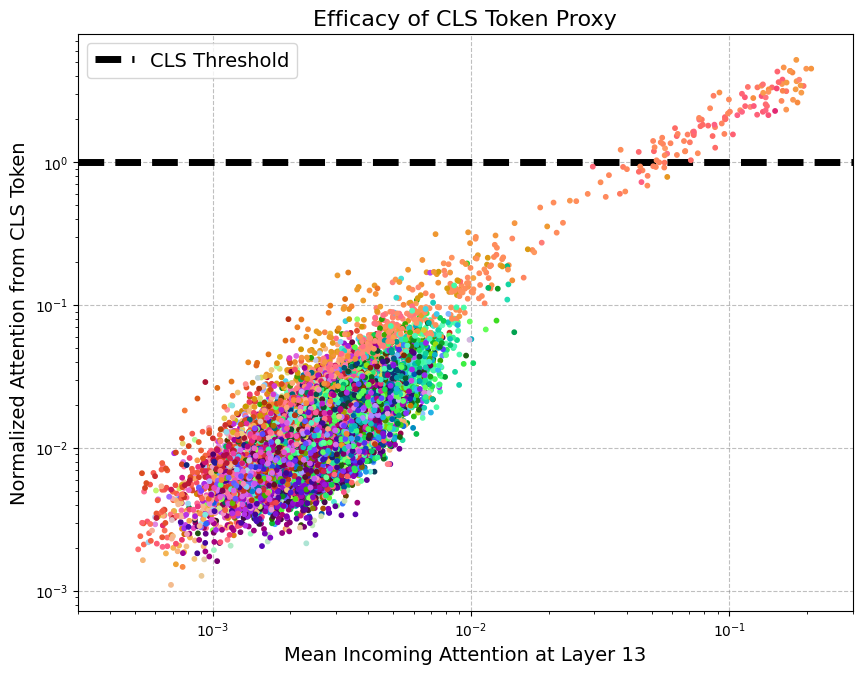

In [5]:
from modeling.image_features import ImageFeatures


detection_layer = 13
mean_incoming_attention = torch.mean(attention_matrix[detection_layer, :, :, ImageFeatures.image_indices], dim=1)
normalized_proxy_attention = attention_matrix[detection_layer, :, 0, ImageFeatures.image_indices] / attention_matrix[detection_layer, :, 0, :1]
rgb_colors: torch.Tensor = torch.load("sandbox/rgb_assignment.pt", map_location=DEVICE)

plt.rcParams["figure.figsize"] = (10.0, 7.5)
plt.grid(axis="both", color="gray", linestyle="--", alpha=0.5)
plt.scatter(
    mean_incoming_attention.flatten().numpy(force=True), normalized_proxy_attention.flatten().numpy(force=True),
    color=rgb_colors.flatten(0, -2).numpy(force=True), s=10, zorder=1212,
)
plt.plot([3e-4, 3e-1], [1, 1], color="black", linestyle="--", linewidth=5.0, label="CLS Threshold")

plt.xlabel(f"Mean Incoming Attention at Layer {detection_layer}", fontsize=14)
plt.xscale("log")
plt.xlim(left=3e-4, right=3e-1)
plt.ylabel(f"Normalized Attention from CLS Token", fontsize=14)
plt.yscale("log")
plt.title("Efficacy of CLS Token Proxy", fontsize=16)

plt.legend(fontsize=14)
plt.savefig(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}/attention_to_CLS_proxy.pdf", bbox_inches="tight")
plt.show()